In [1]:
# Name: Arpon Mandal
# Email: arponmandal69@gmail.com

In [2]:
# Required Libraries
import numpy as np
import pandas as pd
import os, zipfile, shutil, random, time
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import torch
from torch import nn
from torch.optim import SGD, lr_scheduler
from torch.autograd import Variable
from torchvision import transforms as T, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Paths
train_zip_path = "/kaggle/input/dogs-vs-cats/train.zip"
train_images_path = "/kaggle/working/training/"
os.makedirs(train_images_path, exist_ok=True)

# Unzip
with zipfile.ZipFile(train_zip_path) as zip_f:
    zip_f.extractall(train_images_path)

# Prepare Folders
os.makedirs("training/Train/cat", exist_ok=True)
os.makedirs("training/Train/dog", exist_ok=True)
os.makedirs("training/Valid/cat", exist_ok=True)
os.makedirs("training/Valid/dog", exist_ok=True)

# Organize Train/Valid
all_images = os.listdir("training/train")
for file in all_images:
    cls = file.split(".")[0].lower()
    os.rename(f"training/train/{file}", f"training/Train/{cls}/{file}")
shutil.rmtree("training/train")

# Validation Split
for cls in ['cat', 'dog']:
    src = f"training/Train/{cls}"
    dst = f"training/Valid/{cls}"
    val_files = random.sample(os.listdir(src), len(os.listdir(src)) // 5)
    for f in val_files:
        shutil.move(os.path.join(src, f), dst)

# Transforms
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets & Loaders
train_data = ImageFolder("training/Train", transform)
valid_data = ImageFolder("training/Valid", transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {'train': len(train_data), 'val': len(valid_data)}

# Model - Transfer Learning (ResNet18)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Criterion, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [4]:
# Train Model
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

def train_model(model, num_epochs=6):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        scheduler.step()
        print("-")

    print(f"Best Validation Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [5]:
model = train_model(model)


Epoch 1/6
Train Loss: 0.0772 Acc: 0.9694
Val Loss: 0.0362 Acc: 0.9872
-
Epoch 2/6
Train Loss: 0.0340 Acc: 0.9887
Val Loss: 0.0287 Acc: 0.9888
-
Epoch 3/6
Train Loss: 0.0188 Acc: 0.9937
Val Loss: 0.0321 Acc: 0.9896
-
Epoch 4/6
Train Loss: 0.0101 Acc: 0.9975
Val Loss: 0.0312 Acc: 0.9892
-
Epoch 5/6
Train Loss: 0.0080 Acc: 0.9978
Val Loss: 0.0313 Acc: 0.9900
-
Epoch 6/6
Train Loss: 0.0054 Acc: 0.9986
Val Loss: 0.0311 Acc: 0.9892
-
Best Validation Acc: 0.9900


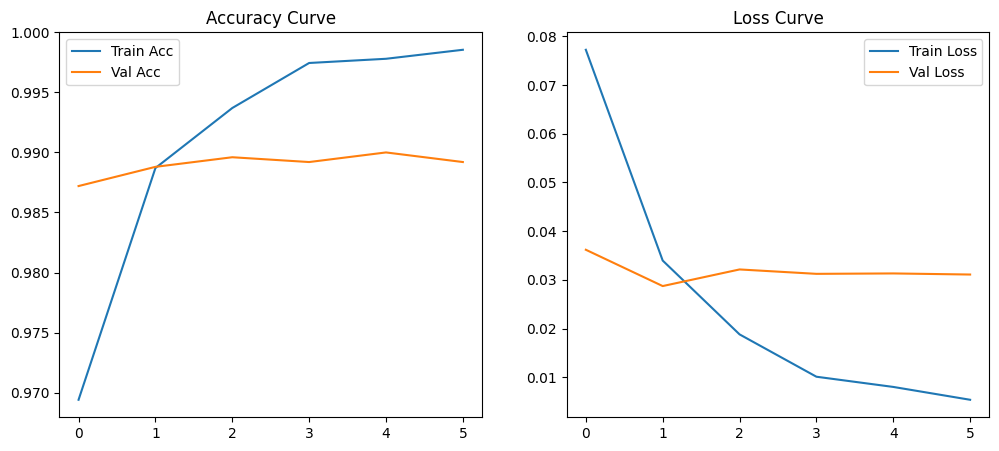

In [6]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [7]:
# Evaluation Metrics on Validation Set
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=valid_data.classes))


Classification Report:
              precision    recall  f1-score   support

         cat       0.99      0.99      0.99      2500
         dog       0.99      0.99      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

